## Import FreeSurfer Subjects Directory Into Mindcontrol
This work flow reads the SUBJECTS_DIR variable, converts all volumetric data from .mgz into .nii.

In [1]:
# Define Modules
import os
import os.path as op
import nibabel as nb
from nipype import MapNode, Workflow, Node
from nipype.interfaces.freesurfer import MRIConvert
from nipype.interfaces.io import DataSink
from nipype.interfaces.utility import IdentityInterface, Function
from glob import glob

ImportError: No module named 'nibabel'

In [25]:
# Print 
mindcontrol_outdir=os.path.abspath('mindcontrol_base_dir')
os.environ["SUBJECTS_DIR"]="/home/jovyan/work/freesurfer"
subjects_dir=os.environ["SUBJECTS_DIR"]
subjectpaths=glob(os.path.join(subjects_dir,"*"))
subjects = [s.split('/')[-1] for s in subjectpaths]
print(subjects)
volumes=["brainmask.mgz","wm.mgz","aparc+aseg.mgz","T1.mgz"]

['sub-01', 'sub-02']


In [26]:
def DataGrabber(subjects_dir, subject, volumes):
    import os
    listofvolumes=[os.path.join(subjects_dir,subject,'mri',volume) for volume in volumes]
    return listofvolumes

170331-18:17:29,746 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/scratch/MindPrepFS/graph_detailed.dot.png (graph2use=exec, simple_form=True).


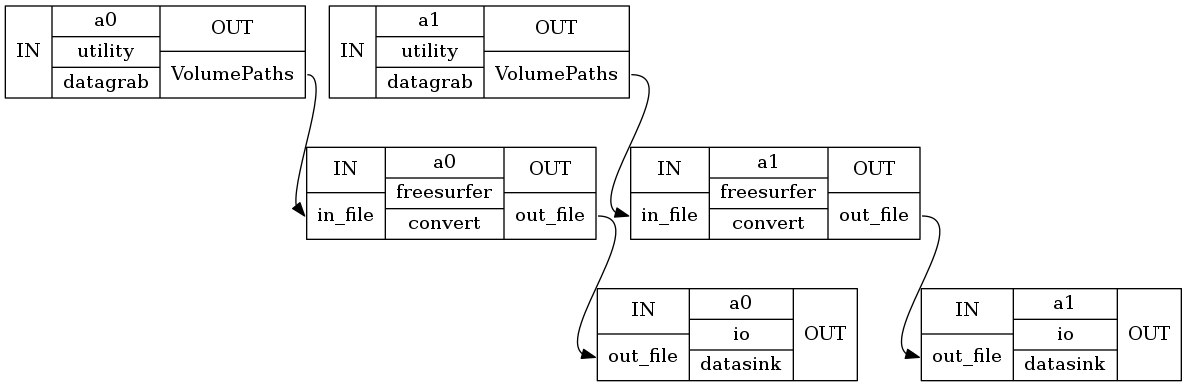

In [27]:
inputs_node = Node(IdentityInterface(fields=['subject_id']), name='inputnode')
inputs_node.iterables=("subject_id",subjects)

DGNode=Node(Function(input_names=["subjects_dir","subject","volumes"],
     output_names=["VolumePaths"],function=DataGrabber),name="datagrab")
DGNode.inputs.subjects_dir=subjects_dir
DGNode.inputs.volumes=volumes

MRIConvertNode=MapNode(MRIConvert(out_type="niigz"),iterfield=["in_file"],name='convert')

DataSinkNode = Node(DataSink(base_directory=mindcontrol_outdir),name='datasink')
mysubs=[('out_file',''),('_subject_id_',''),('_out','')] + [("_convert%d"%index, "") for index in range(len(volumes))]

DataSinkNode.inputs.substitutions=mysubs
wf=Workflow(name="MindPrepFS")
wf.base_dir="./scratch"

wf.connect(inputs_node,"subject_id",DGNode,"subject")
wf.connect(DGNode,"VolumePaths",MRIConvertNode,"in_file")
wf.connect(MRIConvertNode,'out_file',DataSinkNode,'out_file')
from IPython.display import Image
Image(wf.write_graph(graph2use='exec'))

In [28]:
wf.run()

170331-18:17:31,191 workflow INFO:
	 Workflow MindPrepFS settings: ['check', 'execution', 'logging']
170331-18:17:31,343 workflow INFO:
	 Running serially.
170331-18:17:31,346 workflow INFO:
	 Executing node datagrab.a1 in dir: /home/jovyan/work/scratch/MindPrepFS/_subject_id_sub-02/datagrab
170331-18:17:31,384 workflow INFO:
170331-18:17:31,430 workflow INFO:
	 Executing node convert.a1 in dir: /home/jovyan/work/scratch/MindPrepFS/_subject_id_sub-02/convert
170331-18:17:31,512 workflow INFO:
	 Executing node datasink.a1 in dir: /home/jovyan/work/scratch/MindPrepFS/_subject_id_sub-02/datasink
170331-18:17:31,618 interface INFO:
	 sub: /home/jovyan/work/mindcontrol_base_dir/out_file/_subject_id_sub-02/_convert0/brainmask_out.nii.gz -> /home/jovyan/work/mindcontrol_base_dir//sub-02//brainmask.nii.gz
170331-18:17:31,652 interface INFO:
	 sub: /home/jovyan/work/mindcontrol_base_dir/out_file/_subject_id_sub-02/_convert1/wm_out.nii.gz -> /home/jovyan/work/mindcontrol_base_dir//sub-02//wm.nii